# Practical 2

## Preliminary

Load the required libraries and set defaults

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split,
)
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
)
from sklearn.neighbors import (
    KNeighborsClassifier,
    KNeighborsRegressor,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree,
)

sns.set_theme()
seed = 42

## Part 1: Validation Approaches

We will explore the use of the validation set approach in order to estimate the test error rates that result from fitting various linear models on the `Auto` data set.

We use the function `train_test_split()` to split the data into training and validation sets. As there are $392$ observations, we split into two equal sets of size $196$ using the argument `test_size=196`.

It is generally a good idea to set a random seed when performing operations like this that contain an element of randomness, so that the results obtained can be reproduced precisely at a later time. We set the random seed of the splitter with the argument `random_state=seed`.

In [2]:
# load data set
path = 'https://github.com/vladoxNCL/ml_course/raw/main/Auto.csv'
df = pd.read_csv(path)

# change horsepower type to float and fix missing values
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = df['horsepower'].astype(float)
hp_median = df['horsepower'].median()
df['horsepower'] = df['horsepower'].fillna(hp_median)

# add quadratic hp feature
df['horsepower^2'] = df['horsepower'] ** 2

Now we can fit a linear regression using only the observations corresponding to the training set `df_train`:

In [3]:
predictors = ['horsepower', 'horsepower^2']
response = 'mpg'
reg = LinearRegression()

# split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    df[predictors],
    df[response],
    test_size=196,
    random_state=seed,
)

reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_valid_pred = reg.predict(X_valid)

print(f'Training MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Validation MSE: {mean_squared_error(y_valid, y_valid_pred)}')

Training MSE: 19.035743133470824
Validation MSE: 20.673515479990726


### Cross-Validation

Lets now check the MSE using 5-Fold, 10-Fold, and Leave-One-Out (LOO) cross-validation.

For this, we will use `sklearn`'s `cross_val_score()` function:

In [4]:
folds = {
    '5-Fold': 5,
    '10-Fold': 10,
    'LOO': df.shape[0],
}

for key, val in folds.items():
    scores = cross_val_score(
        reg, df[predictors], df[response],
        cv=val, scoring='neg_mean_squared_error',
    )
    print(f'{key}-Fold MSE: {-scores.mean()}')

5-Fold-Fold MSE: 25.22445101258885
10-Fold-Fold MSE: 22.136544856423143
LOO-Fold MSE: 20.019475910738382


The CV approach gives a better estimation of real-world test performance, as all of the data is being utilised.


### Hands On

For the `Credit` data set, predict `Balance` from the remaining features using KNN regression. Some of these features are categorical, and will need to be (one-hot) encoded first.

Use **5-Fold cross-validation** to find the best $K \in \{1, 2, \dots, 10\}$ with respect to **R^2 Score**.

In [5]:
path = 'https://github.com/vladoxNCL/ml_course/raw/main/Credit.csv'
df = pd.read_csv(path)

# your code here

## Part 2: Classification

In class, we learnt about a few different classification models:

1. Logistic regression
2. KNN
3. Naïve Bayes
4. Decision trees
5. Ensemble methods (e.g., random forests)
6. SVCs

Lets compare their performance on the `Default` dataset to predict `default` from `student`, `balance`, and `income`, using 5-Fold CV to select the best model.


In [6]:
path = 'https://github.com/vladoxNCL/ml_course/raw/main/Default.csv'

df = pd.read_csv(path)
for col in ['default', 'student']:
    df[col] = df[col].map({'No': 0, 'Yes': 1})
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [7]:
preds = ['student', 'balance', 'income']
response = 'default'

X_train, X_test, y_train, y_test = train_test_split(
    df[preds],
    df[response],
    test_size=0.1,
    random_state=seed,
)

clfs = {
    'LR': make_pipeline(StandardScaler(), LogisticRegression(random_state=seed)),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'GNB': make_pipeline(StandardScaler(), GaussianNB()),
    'DT': DecisionTreeClassifier(random_state=seed),
    'RF': RandomForestClassifier(random_state=seed),
    'SVC': make_pipeline(StandardScaler(), SVC(random_state=seed)),
}

for clf_name, clf in clfs.items():
    scores = cross_val_score(
        clf, X_train, y_train,
        cv=5, scoring='accuracy',
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accu = accuracy_score(y_test, preds)
    print(f'{clf_name} Accuracy\t Train CV: {scores.mean():.3f}\t Test: {accu:.3f}')

LR Accuracy	 Train CV: 0.974	 Test: 0.968
KNN Accuracy	 Train CV: 0.970	 Test: 0.962
GNB Accuracy	 Train CV: 0.971	 Test: 0.958
DT Accuracy	 Train CV: 0.955	 Test: 0.953
RF Accuracy	 Train CV: 0.969	 Test: 0.963
SVC Accuracy	 Train CV: 0.973	 Test: 0.962


All the models perform really well. However, the edge goes to **logistic regression**, since it is the most interpretable.


### Hyper-parameter tuning

As an exercise, lets try to improve the accuracy of **random forests** and **SVMs** through hyper-parameter tuning:

In [8]:
# set up the model and hyperparameter grid
rf_clf = RandomForestClassifier(random_state=seed)
param_grid = {
    'n_estimators': list(range(1, 10)),
    'max_depth': list(range(1, 10)),
}

# perform cross-validation and hyperparameter tuning on the training set
grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# evaluate the model on the test set
y_pred = grid_search.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# best hyperparameters and cross-validation score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Score: {grid_search.best_score_}')
print(f'Test Accuracy: {acc:.3f}')

Best Parameters: {'max_depth': 4, 'n_estimators': 8}
Best CV Score: 0.9732222222222223
Test Accuracy: 0.965


In [9]:
svc_clf = make_pipeline(StandardScaler(), SVC(random_state=seed))
param_grid = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
}

# perform cross-validation and hyperparameter tuning on the training set
grid_search = GridSearchCV(svc_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# evaluate the model on the test set
y_pred = grid_search.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# Best hyperparameters and cross-validation score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Score: {grid_search.best_score_}')
print(f'Test Accuracy: {acc:.3f}')

Best Parameters: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best CV Score: 0.9732222222222223
Test Accuracy: 0.964


Hyper-parameter tuning improved the performance of both RF and SVC. However, their performance didn't match **logistic regression**, which should still be preferred due to its interpretability.

Lets see what info we can get from the LR model:

In [10]:
clf = LogisticRegression(random_state=seed)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print('Coefficients:')
for feat, coef in zip(X_test.columns, clf.coef_[0]):
    print(f'{feat}: {coef:.3f}')

Coefficients:
student: -0.565
balance: 0.006
income: 0.000


This tells us that `student` is **negatively** correlated with defaulting, while `balance` is **positively** correlated with defaulting (although to a lesser extent), and `income` is *uncorrelated* with defaulting.

Another explainable model is generated by decision trees:

Decision Tree Accuracy: 0.968

Feature Importances:
student	 0.0000
balance	 0.9742
income	 0.0258



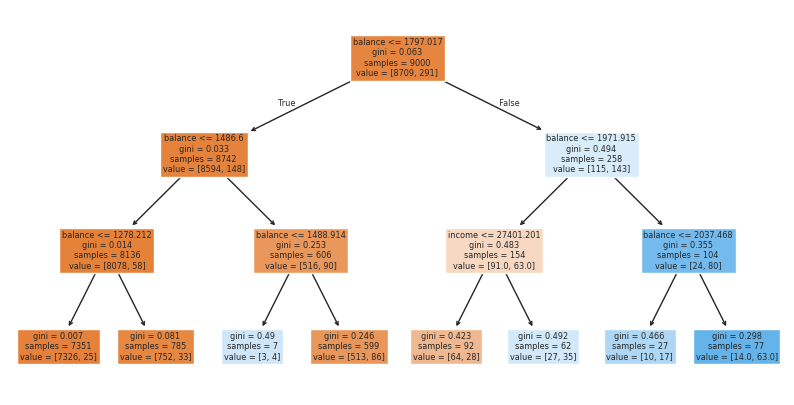

In [11]:
clf = DecisionTreeClassifier(max_depth=3, random_state=seed)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, preds)}\n')

imps = clf.feature_importances_
print('Feature Importances:')
for feat, imp in zip(X_train.columns, imps):
    print(f'{feat}\t {imp:.4f}')
print('')

plt.figure(figsize=(10, 5))
plot_tree(clf, feature_names=X_train.columns, filled=True);

For this model, `balance` is the most important feature, followed by `income` and finally `student` is not important.

The colours in the plot represent the **classes**: *red* means $0$ (don't default) and *blue* means $1$ (default).

## Hands On

Use the *Wine* dataset from scikit-learn and the Support Vector Classifier (SVC) model to perform 10-fold cross-validation.

1. Load the Wine dataset from *scikit-learn*.
2. Train/test split your data with a 90/10 proportion.
3. Create an SVC classifier.
4. Perform 10-fold cross-validation on the *training* data.
5. Print the cross-validation scores and the mean score.
6. Use the `GridSearchCV` function to tune the `'C'`, `'kernel'`, `'gamma'`, and `'degree'` hyper-parameters.
7. Verify the quality of the resulting hyper-parameters over the *test* data.

In [ ]:
wine = load_wine()
wine.keys()

# your code here